In [49]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.interpolate import interp1d

# 常量定义
G = const.G # 万有引力常数, m^3 kg^-1 s^-2
c = const.c  # 光速, m/s
msun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

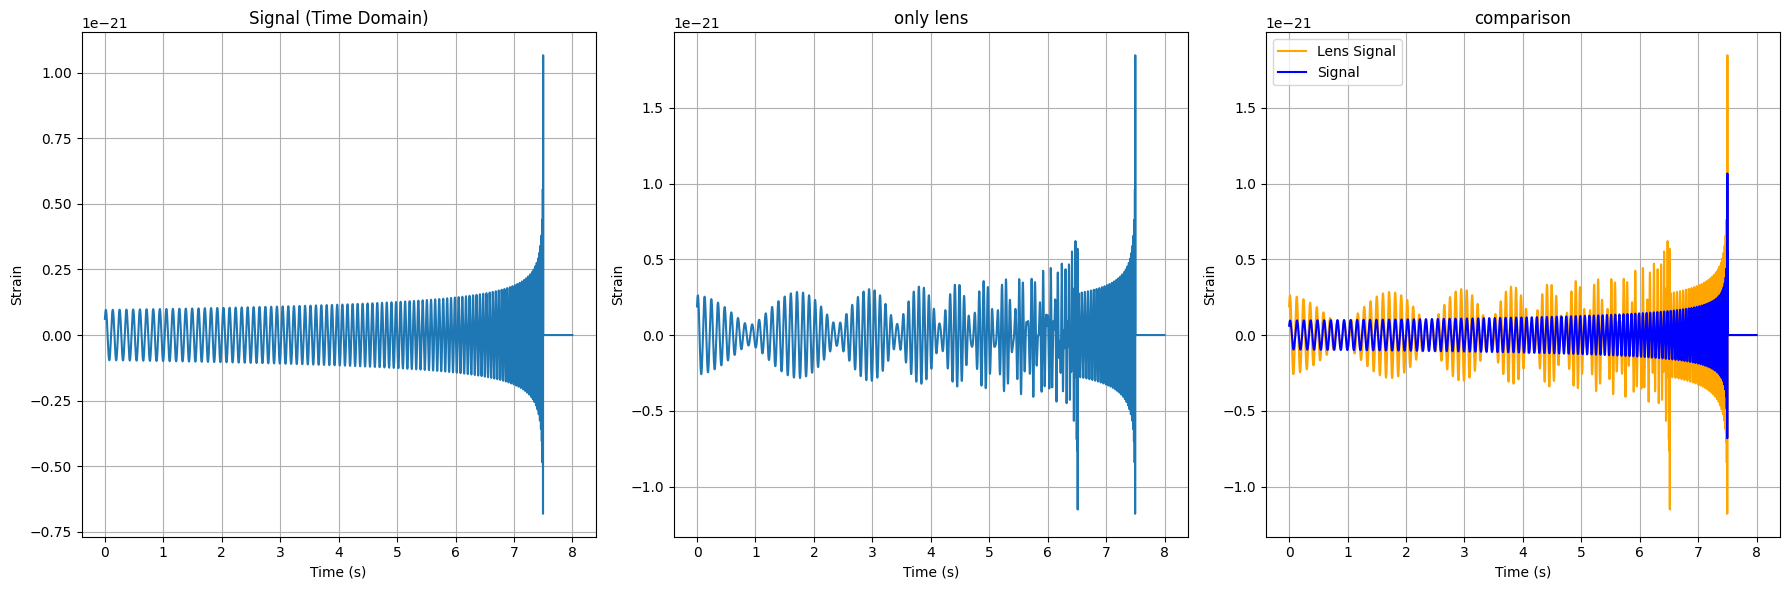

In [50]:
# 初始参数 - GW150914
m1 = 40  # 第一个黑洞质量（太阳质量）
m2 = 30  # 第二个黑洞质量（太阳质量）
# M_chirp = (m1 * m2 / (m1 + m2) ** 2) ** (3/5) * (m1 + m2)  # 啁啾质量
M_chirp = (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5)
M_chirp = M_chirp * msun  # 转换为kg

# 透镜参数
mlz = 5e4 * msun  # 透镜质量
y = 0.5  # 影响参数

# 采样参数 - 与LIGO一致
fs = 4096  # 采样率调整为LIGO的标准采样率
dt = 1 / fs
t = np.arange(0, 8, dt)  # 时间范围调整，使其更加聚焦于合并前的最后阶段
t_len = t[-1] - t[0]
N = len(t)

# 引力波参数 - 调整以匹配GW150914
tc = 7.5  # 合并时间，选择使信号在最后时刻达到峰值
phi_c = 0.25 * np.pi

# SIS透镜参数
r = 1500 * 1e6 * pc  # 源距离 

# 函数：引力波波形生成（啁啾信号）
def generate_gw_signal(t):
    # 确保在合并前截止
    valid_idx = t < tc
    t_valid = t[valid_idx]
    # 计算Θ(t)，控制信号的频率演化
    Theta = c ** 3 * (tc - t_valid) / (5 * G * M_chirp)
    # 计算振幅部分
    A = (G * M_chirp / (c ** 2 * r)) * Theta ** (-1 / 4)

    # 原始相位计算
    phase = 2 * phi_c - 2 * Theta ** (5 / 8)

    # 计算波形
    h = np.zeros_like(t)
    h[valid_idx] = A * np.cos(phase)
    return h


## 函数：透镜放大因子（时域方法2）
def lens_time(h_original, t, y):
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1 / y)  # 主像
    mu_minus = np.sqrt(-1 + 1 / y) if y < 1 else 0  # 次像

    # 计算物理时间延迟
    td = 8 * y * mlz * G /(c ** 3) # 秒
    # 创建插值函数
    interp_func = interp1d(t, h_original, kind='cubic', bounds_error=False, fill_value=0)
    # 创建延迟时间点
    t_delayed = t + td

    # 计算延迟信号
    h_delayed = interp_func(t_delayed)

    # 透镜化效应：原始信号和延迟信号的组合
    h_lensed = mu_plus * h_original

    # 只有在y<1时才有次像
    if y < 1:
        h_lensed = h_lensed - mu_minus * h_delayed  # 次像有π相位差(负号)
    return h_lensed


# 计算引力波信号
h = generate_gw_signal(t)
# h = h * 0.25
h_lens = lens_time(h, t, y)
# 绘制原始信号的时域
plt.figure(figsize=(18, 6))
# 时域原始信号
plt.subplot(131)
plt.plot(t, h)
plt.title('Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.subplot(132)
plt.plot(t, h_lens, label='Lens Signal(T)')
plt.title('only lens')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.tight_layout()
plt.subplot(133)
plt.plot(t, h_lens, 'orange', label='Lens Signal')
plt.plot(t, h, 'b', label='Signal')
plt.title('comparison')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

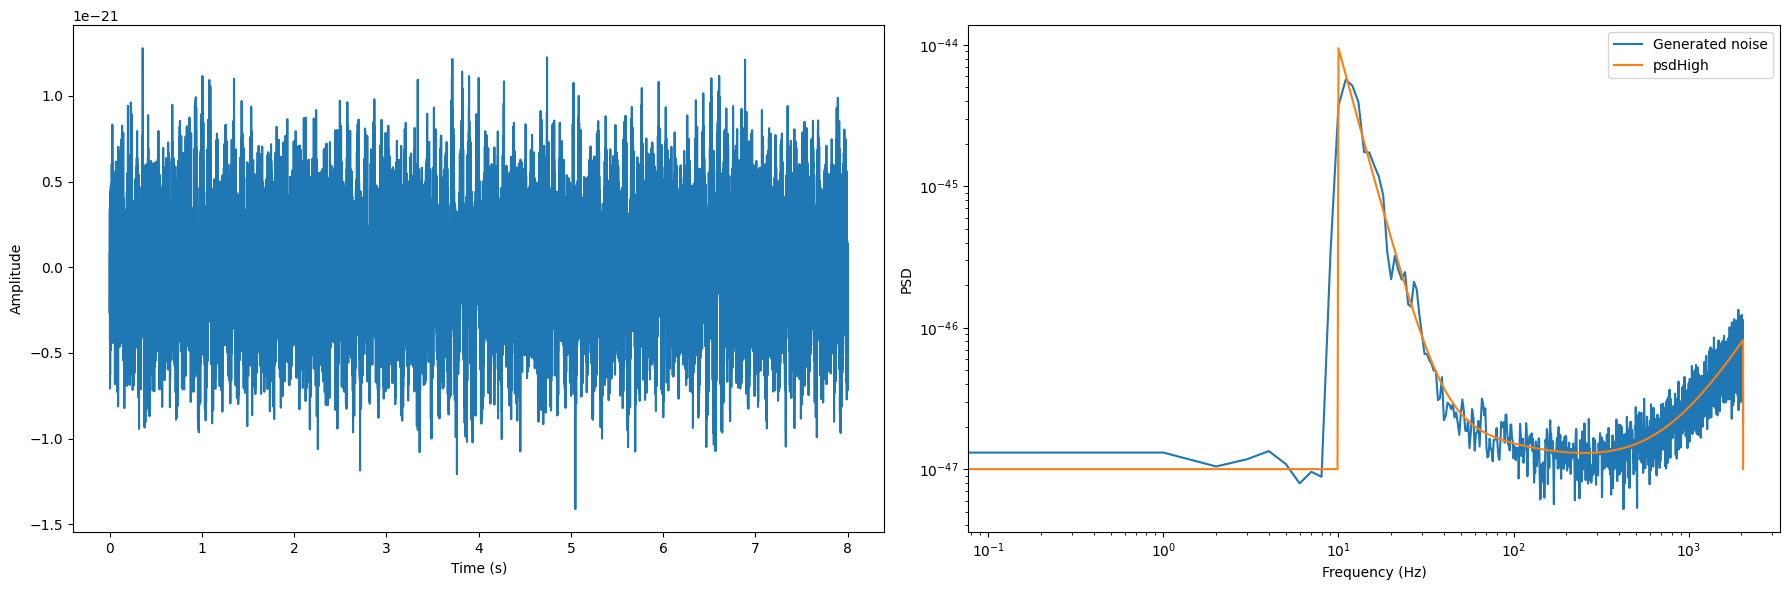

In [51]:
from scipy.io import savemat
import pycbc.noise
import pycbc.psd
from scipy.signal import welch

fs = 4096  # This seems to be missing in your code
N = 8 * fs  # Total number of samples for 20 seconds
flow = 10
delta_f = 1 / 8
delta_t = 1 / fs
t = np.arange(0, N) * delta_t

# Generate PSD and noise
f_len = int(N // 2) + 1
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, flow)
psdHigh = np.maximum(psdHigh, 1e-47)
output_noise = pycbc.noise.noise_from_psd(N, delta_t, psdHigh)

# Plot time domain
fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t, output_noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Calculate PSD with Welch method - use proper parameters
f, pxx = welch(output_noise, fs=fs, nperseg=4096, noverlap=2048, scaling='density')

# Convert PyCBC PSD to numpy array with correct frequency axis
psd_freq = np.arange(len(psdHigh)) * delta_f

# Plot frequency domain
plt.subplot(122)
plt.plot(f, pxx, label='Generated noise')
plt.plot(psd_freq, psdHigh, label='psdHigh')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.tight_layout()
plt.show()

savemat('noise.mat', {'noise': output_noise, 'psd': psdHigh})

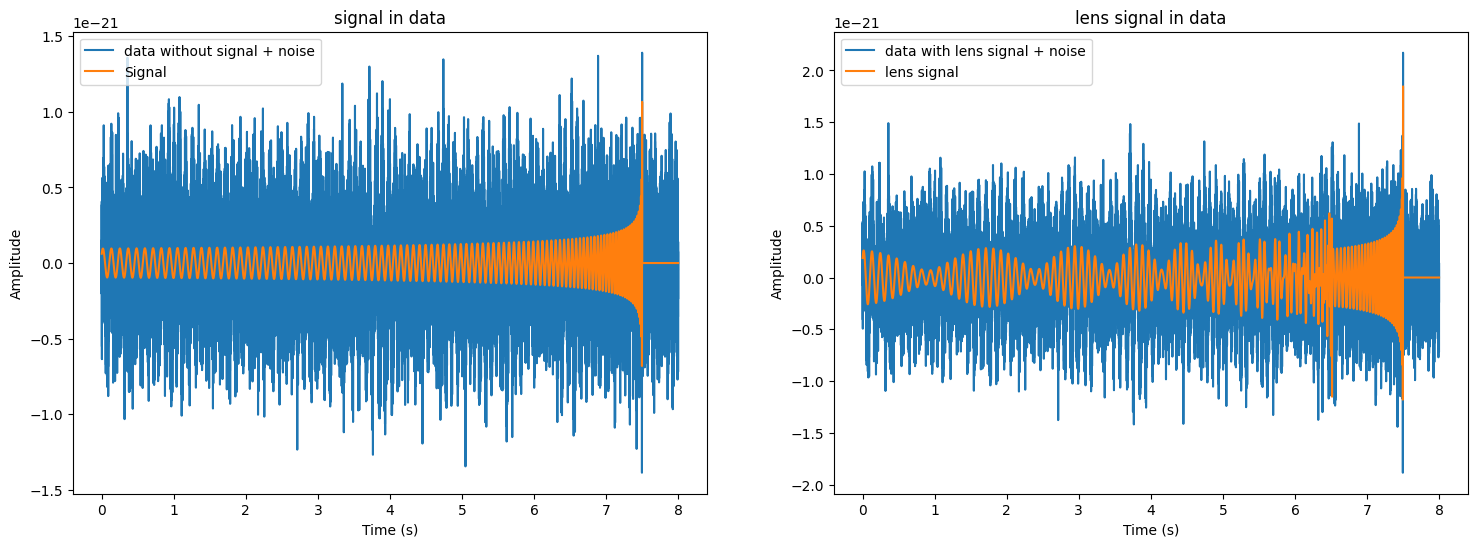

In [52]:
data = h + output_noise
data_lens = h_lens + output_noise
# data = h_windowed + output_noise
# data_lens = h_lens_windowed + output_noise

fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t, data, label='data without signal + noise')
# plt.plot(t, h_windowed, label='Signal')
plt.plot(t, h, label='Signal')
plt.title('signal in data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.plot(t, data_lens, label='data with lens signal + noise')
# plt.plot(t, h_lens_windowed, label='lens signal')
plt.plot(t, h_lens, label='lens signal')
plt.title('lens signal in data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

savemat('data_without_lens.mat', {'data': data, 'samples': fs})
savemat('data.mat', {'data': data_lens, 'samples': fs})

In [53]:
import pycbc.filter
from pycbc.types import TimeSeries, FrequencySeries
import pandas as pd

# 确保所有变量都是numpy数组
h_np = np.array(h, dtype=float)
h_lens_np = np.array(h_lens, dtype=float)
if hasattr(psdHigh, 'numpy'):
    psdHigh_np = psdHigh.numpy()
else:
    psdHigh_np = np.array(psdHigh, dtype=float)


# PyCBC方法计算信噪比
def calculate_snr_pycbc(signal, psd, fs):
    """
    使用PyCBC的matched_filter计算信噪比
    """
    # 创建PyCBC的TimeSeries对象
    delta_t = 1.0 / fs
    ts_signal = TimeSeries(signal, delta_t=delta_t)

    # 创建PyCBC的FrequencySeries对象
    delta_f = 1.0 / (len(signal) * delta_t)
    # 确保PSD长度与频率点数匹配

    psd_series = FrequencySeries(psd, delta_f=delta_f)

    # 使用matched_filter计算SNR
    # 模板与信号匹配（两者相同）
    snr = pycbc.filter.matched_filter(ts_signal, ts_signal, psd=psd_series, low_frequency_cutoff=10.0)
    # 获取最大SNR值
    max_snr = abs(snr).max()
    return float(max_snr)

# 计算SNR
print("\n===== 使用PyCBC方法计算信噪比 =====")
try:
    snr_pycbc_h = calculate_snr_pycbc(h_np, psdHigh_np, fs)
    snr_pycbc_h_lens = calculate_snr_pycbc(h_lens_np, psdHigh_np, fs)
    if snr_pycbc_h is not None and snr_pycbc_h_lens is not None:
        print(f"未透镜化信号信噪比 (PyCBC): {snr_pycbc_h:.4f}")
        print(f"透镜化信号信噪比 (PyCBC): {snr_pycbc_h_lens:.4f}")
        print(f"透镜效应导致的信噪比增强: {snr_pycbc_h_lens / snr_pycbc_h:.4f}倍")
    else:
        print("PyCBC方法计算失败")
except Exception as e:
    print(f"PyCBC方法出错: {e}")
    snr_pycbc_h = None
    snr_pycbc_h_lens = None


===== 使用PyCBC方法计算信噪比 =====
未透镜化信号信噪比 (PyCBC): 34.4735
透镜化信号信噪比 (PyCBC): 68.9674
透镜效应导致的信噪比增强: 2.0006倍


In [54]:
I = np.abs(-1 + 1/y) / np.abs(1 + 1/y)
td = 8 * y * mlz * G /(c ** 3) # 秒
print(f'm1：{m1}')
print(f'm2：{m2}')
print(f'啁啾质量：{M_chirp / msun:.2f}')
print(f'合并时间：{tc:.4f}')
print(f'源距离：{r / 1e6 / pc :.4f}')
print(f'天体透镜质量：{mlz / msun:.4e}')
print(f"y:{y:.4f}")
print(f"通量比:{I:.4f}")
print(f"时间延迟:{td:.4f}")
print(f"相位：{phi_c/np.pi:.4f}")

m1：40
m2：30
啁啾质量：30.09
合并时间：7.5000
源距离：1500.0000
天体透镜质量：5.0000e+04
y:0.5000
通量比:0.3333
时间延迟:0.9854
相位：0.2500


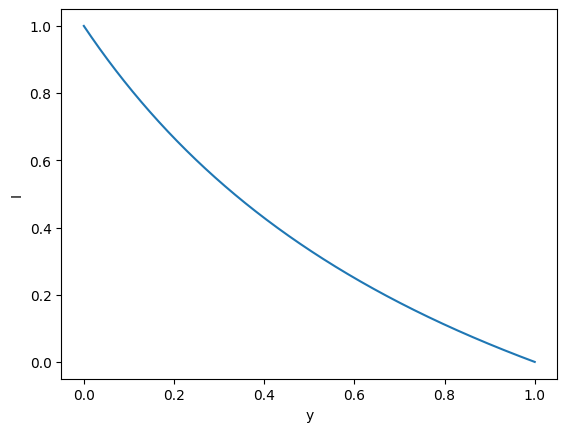

In [55]:
y = np.linspace(1e-10,1,1000)
I = np.abs(-1 + 1/y) / np.abs(1 + 1/y)
plt.plot(y,I)
plt.xlabel('y')
plt.ylabel('I')
plt.show()

In [56]:
from pycbc.filter import match
y = 0.5
def innerprodpsd(xVec, yVec, sampFreq, psdVals):
    """
    计算考虑PSD的内积
    """
    # Ensure inputs are numpy arrays
    xVec = np.array(xVec, dtype=float)
    yVec = np.array(yVec, dtype=float)
    psdVals = np.array(psdVals,dtype=float)
    
    # Convert PSD to numpy array if it's a PyCBC object
    if hasattr(psdVals, 'numpy'):
        psdVals_np = psdVals.numpy()
    else:
        psdVals_np = np.array(psdVals, dtype=float)
    # 确保输入向量长度一致
    if len(xVec) != len(yVec):
        # 调整长度使其匹配
        min_len = min(len(xVec), len(yVec))
        xVec = xVec[:min_len]
        yVec = yVec[:min_len]

    nSamples = len(xVec)
    # 计算FFT
    fftX = np.fft.fft(xVec)
    fftY = np.fft.fft(yVec)
    # 构建完整的PSD向量
    if psdVals.shape[0] > 1:  # 确保有多于一个元素
        psdVec4Norm = np.concatenate([psdVals, psdVals[-2:0:-1]])
    else:
        # 处理特殊情况
        psdVec4Norm = np.zeros(nSamples)
        psdVec4Norm[0] = psdVals[0]

    # 确保长度匹配
    if len(fftX) > len(psdVec4Norm):
        psdVec4Norm = np.pad(psdVec4Norm, (0, len(fftX) - len(psdVec4Norm)), 'constant',
                             constant_values=psdVec4Norm[-1])
    elif len(fftX) < len(psdVec4Norm):
        psdVec4Norm = psdVec4Norm[:len(fftX)]
    # 计算内积
    inner_product = np.sum((fftX * np.conj(fftY)) / psdVec4Norm) / (sampFreq * nSamples)

    # 返回实部
    return np.real(inner_product)

    
def analyze_mismatch(data, h_lens, samples, psdHigh):
    # Convert inputs to CuPy arrays
    data_cupy = np.asarray(data)
    h_lens_cupy = np.asarray(h_lens)
    # Calculate match value
    match_value = (innerprodpsd(h_lens_cupy, data_cupy, samples, psdHigh) /
                   np.sqrt(innerprodpsd(h_lens_cupy, h_lens_cupy, samples, psdHigh) *
                           innerprodpsd(data_cupy, data_cupy, samples, psdHigh)))

    # Calculate mismatch
    epsilon = 1 - match_value
    return epsilon

def pycbc_match(signal1, signal2, psd, cutoff):
    if not isinstance(signal1, (TimeSeries, FrequencySeries)):
        sample_rate = 4096 
        delta_t = 1.0 / sample_rate
        signal1 = TimeSeries(signal1, delta_t=delta_t)
    
    if not isinstance(signal2, (TimeSeries, FrequencySeries)):
        sample_rate = 4096
        delta_t = 1.0 / sample_rate
        signal2 = TimeSeries(signal2, delta_t=delta_t)
    
    if not isinstance(psd, FrequencySeries):
        delta_f = 1.0 / (len(signal1) * signal1.delta_t)
        psd = FrequencySeries(psd, delta_f=delta_f)
    
    # Calculate match
    matchFitness, idx = match(signal1, signal2, psd=psd, low_frequency_cutoff=cutoff)
    mismatch = 1 - matchFitness
    return matchFitness,mismatch


mismatch = analyze_mismatch(h,h_lens, fs, psdHigh)
match_signal,mismatch_pycbc_signal = pycbc_match(h,h_lens,psdHigh,10)
match_lens_signal,mismatch_pycbc_lens_signal = pycbc_match(h_lens,h_lens,psdHigh,10)
unlens_threshold = 1 / snr_pycbc_h
lens_threshold = 1 / snr_pycbc_h_lens
print(f"mismatch:{mismatch:.4f}")
print(f"match_signal:{match_signal:.4f}")
print(f"match_lens_signal:{match_lens_signal:.4f}")
print(f"mismatch_pycbc:{mismatch_pycbc_signal:.4f}")
print(f"mismatch_pycbc_lens:{mismatch_pycbc_lens_signal:.4f}")
print(f"unlens_threshold:{unlens_threshold:.4f}")
print(f"lens_threshold:{lens_threshold:.4f}")

mismatch:0.1026
match_signal:0.8661
match_lens_signal:1.0000
mismatch_pycbc:0.1339
mismatch_pycbc_lens:-0.0000
unlens_threshold:0.0290
lens_threshold:0.0145


/tmp/ipykernel_12264/3478033462.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  psdVals = np.array(psdVals,dtype=float)
